In [1]:
import pandas as pd
import requests, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import datetime, timedelta

### 自動生成 24 個月份的列表，從 2021 年 1 月開始

In [2]:
def generate_date_list(start_date, months):
    date_list = []
    start = datetime.strptime(start_date, "%Y%m%d")
    for i in range(months):
        year_month = start + timedelta(days=30 * i)  # 每次增加一個月
        date_str = year_month.strftime("%Y%m01")  # 每個月的第一天
        date_list.append(date_str)
    return date_list

### 下載證交所資料

In [3]:
def fetch_data(date, stock_no):
    url = f'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={stock_no}'
    html = requests.get(url,verify=False)
    content = json.loads(html.text)
    stock_data = content['data']
    col_name = content['fields']
    df = pd.DataFrame(data=stock_data, columns=col_name)
    return df

### 將民國年轉換為西元年

In [4]:
def convert_minguo_to_ad(date_str):
    year, month, day = date_str.split('/')
    year = str(int(year) + 1911)
    return f'{year}-{month}-{day}'

### 爬取證交所 2330.tw 股價

In [5]:
# 生成 36 個月份的日期列表
date_list = generate_date_list('20210601', 36)
stock_no = '2330'
df_list = []

for date in date_list:
    df = fetch_data(date, stock_no)
    df_list.append(df)

# 將多個月份的資料合併，只使用前 35 個月資料
df_twse = pd.concat(df_list[:-1])

# 將日期轉換為西元年
df_twse['日期'] = df_twse['日期'].apply(convert_minguo_to_ad)
# 轉換為 datetime 格式並設置為索引
df_twse['日期'] = pd.to_datetime(df_twse['日期'], format='%Y-%m-%d')
df_twse.set_index('日期', inplace=True)

df_twse.tail()

c:\Users\marti\anaconda3\lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\marti\anaconda3\lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\marti\anaconda3\lib\site-packages\urllib3\connectionpool.py:1103: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.twse.com.tw'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
c:\Users\marti\anaconda3\lib\site-packages\urllib3\connect

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
日期,,,,,,,,
2024-03-25,"21,223,414","16,612,693,369",783.00,788.00,779.00,780.00,-5.00,"24,794"
2024-03-26,"43,103,294","33,847,261,033",788.00,792.00,776.00,782.00,+2.00,"35,046"
2024-03-27,"19,732,209","15,418,346,943",785.00,785.00,779.00,779.00,-3.00,"21,006"
2024-03-28,"28,393,398","21,889,883,699",774.00,776.00,768.00,769.00,-10.00,"39,848"
2024-03-29,"20,212,820","15,682,908,766",769.00,781.00,768.00,779.00,+10.00,"18,110"


### 修正表格部分欄位資料型態並轉換為數字型態

In [6]:
df_twse['開盤價'] = pd.to_numeric(df_twse['開盤價'].str.replace(',', ''), errors='coerce')
df_twse['收盤價'] = pd.to_numeric(df_twse['收盤價'].str.replace(',', ''), errors='coerce')
df_twse['最高價'] = pd.to_numeric(df_twse['最高價'].str.replace(',', ''), errors='coerce')
df_twse['最低價'] = pd.to_numeric(df_twse['最低價'].str.replace(',', ''), errors='coerce')

### 1. 計算技術指標（SMA、RSI、MACD）

In [7]:
# RSI 計算
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [8]:
# 計算SMA (簡單移動平均)
df_twse['SMA_20'] = df_twse['收盤價'].rolling(window=20).mean()

# 計算 RSI
df_twse['RSI_14'] = calculate_rsi(df_twse['收盤價'])

# 計算MACD
short_window = 12
long_window = 26
signal_window = 9
df_twse['EMA12'] = df_twse['收盤價'].ewm(span=short_window, adjust=False).mean()
df_twse['EMA26'] = df_twse['收盤價'].ewm(span=long_window, adjust=False).mean()
df_twse['MACD'] = df_twse['EMA12'] - df_twse['EMA26']
df_twse['MACD_Signal'] = df_twse['MACD'].ewm(span=signal_window, adjust=False).mean()
df_twse.tail()

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,SMA_20,RSI_14,EMA12,EMA26,MACD,MACD_Signal
日期,,,,,,,,,,,,,,
2024-03-25,"21,223,414","16,612,693,369",783.0,788.0,779.0,780.0,-5.00,"24,794",749.70,64.705882,765.083765,735.688622,29.395143,31.279271
2024-03-26,"43,103,294","33,847,261,033",788.0,792.0,776.0,782.0,+2.00,"35,046",753.90,64.071856,767.686263,739.119094,28.567169,30.736851
2024-03-27,"19,732,209","15,418,346,943",785.0,785.0,779.0,779.0,-3.00,"21,006",757.95,56.551724,769.426838,742.073235,27.353602,30.060201
2024-03-28,"28,393,398","21,889,883,699",774.0,776.0,768.0,769.0,-10.00,"39,848",761.90,44.274809,769.361170,744.067811,25.293360,29.106833
2024-03-29,"20,212,820","15,682,908,766",769.0,781.0,768.0,779.0,+10.00,"18,110",766.40,55.284553,770.844067,746.655380,24.188687,28.123204


In [9]:
# 將欄位名稱改為英文
df_twse.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '收盤價': 'Close', '成交筆數': 'Volume'}, inplace=True)
# 移除有 NaN 值的列
df_twse.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
df_twse['Volume'] = pd.to_numeric(df_twse['Volume'].str.replace(',', ''), errors='coerce')

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_percentage_error
import numpy as np

### 切分訓練與測試資料

In [11]:
# 移除 NaN 值
df_twse.dropna(subset=['SMA_20', 'RSI_14', 'MACD', 'MACD_Signal'], inplace=True)

# 建立未來一天的股價作為目標變量
df_twse['Future_Price'] = df_twse['Close'].shift(-1)
# 使用第36個月的第一個資料填補最後一天空值
df_36th_month = df_list[-1]
first_price_of_36th_month = float(df_36th_month.iloc[0]['收盤價'].replace(',', ''))
df_twse['Future_Price'].iloc[-1] = first_price_of_36th_month

# 準備特徵和標籤
X = df_twse[['SMA_20', 'RSI_14', 'MACD', 'MACD_Signal']]
y = df_twse['Future_Price']

# 分割資料為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False  # 保留時間順序
)

C:\Users\marti\AppData\Local\Temp\ipykernel_5240\926078494.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_twse['Future_Price'].iloc[-1] = first_price_of_36th_month


In [12]:
# 6. ARIMA 模型
# 需要僅使用 y_train 來進行 ARIMA 模型訓練，因為 ARIMA 是單變量模型
arima_order = (5, 0, 0)  # (p, d, q) 的預設值，可以根據需要調整
arima_model = sm.tsa.arima.ARIMA(y_train, order=arima_order)
arima_model_fit = arima_model.fit()
y_pred_arima = arima_model_fit.forecast(steps=len(y_test))  # 使用測試集進行預測


c:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\marti\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\marti\anaconda3\lib\site-

In [13]:
# 相對誤差計算
mape_arima = mean_absolute_percentage_error(y_test, y_pred_arima)
accuracy_arima = 1 - mape_arima
print(accuracy_arima)

0.9004376584914988


In [14]:
dates = y_test.index  # 測試集對應的日期
six_months_ago = dates.max() - pd.DateOffset(months=6)  # 六個月前的日期
recent_six_months = dates[dates >= six_months_ago]  # 取出最近六個月的日期範圍
# 取原始股價近六個月
y_test_recent = y_test.loc[recent_six_months]
y_test_recent = y_test_recent.sort_index()
# 取預測股價近六個月
y_pred_arima_series = pd.Series(np.array(y_pred_arima), index=y_test.index)
y_pred_arima_recent = y_pred_arima_series.loc[recent_six_months]
y_pred_arima_recent = y_pred_arima_recent.sort_index()

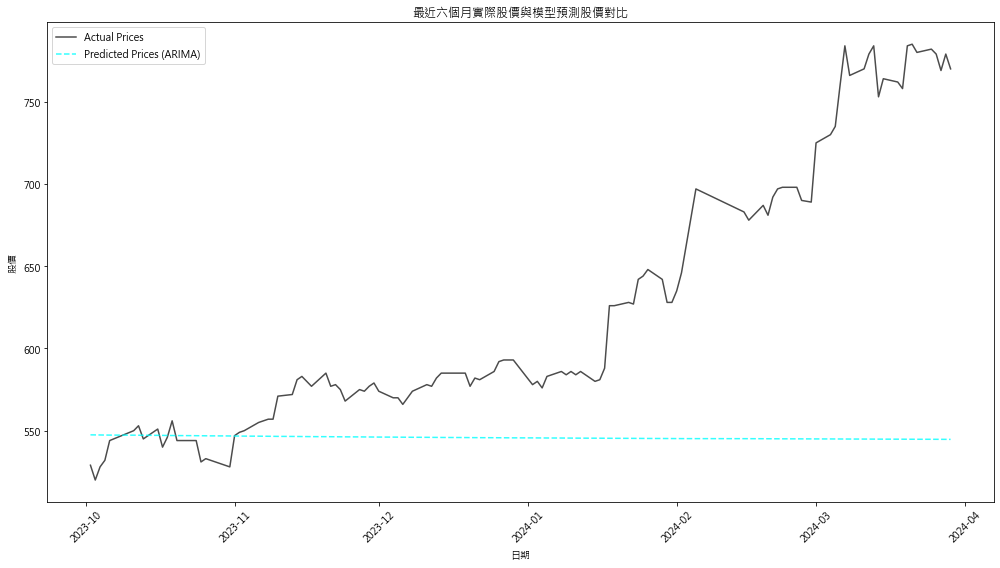

In [15]:
plt.figure(figsize=(14, 8))
# 繪製實際股價曲線
plt.plot(y_test_recent.index, y_test_recent, label='Actual Prices', color='black', alpha=0.7)
# 繪製 ARIMA 預測結果
plt.plot(y_pred_arima_recent.index, y_pred_arima_recent, label='Predicted Prices (ARIMA)', color='cyan', linestyle='--', alpha=0.8)
# 設置中文字體
plt.rcParams['font.family'] = 'Microsoft JhengHei'
plt.rcParams['font.sans-serif'] = 'Microsoft JhengHei'

# 添加圖例和標題
plt.title('最近六個月實際股價與模型預測股價對比')
plt.xlabel('日期')
plt.ylabel('股價')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# 保存圖表到 PNG 文件
plt.savefig('stock_price_predictions_six_months_with_arima.png')

# 顯示圖表
plt.show()